# Spinup of a subtropical gyre in a 1.5 layer ocean

In this example we will simulate the spin up of a subtropical gyre, driven by surface wind stress, in a reduced gravity model. This model consists of an active upper layer and an infinitely deep lower layer that is at rest. We use this example to show you how to
- adding custom terms to the equation
- set up a domain on a sphere
- control the computation of the Coriolis parameter

But first to the physics. The motion is governed by the following equations

- momentum equation along the x direction:
  
  $\frac{\partial u}{\partial t} = fv -\frac{g}{r \cos\theta}\frac{\partial \eta}{\partial \lambda} + \frac{\tau}{\rho_0 H_e} - ru$
  
- momentum equation along the y direction:

  $\frac{\partial v}{\partial t} = -fu -\frac{g}{r}\frac{\partial \eta}{\partial \theta} -rv$

- the continuity equation:
  
  $\frac{\partial \eta}{\partial t} = -\frac{H}{r\cos\theta}\left(\frac{\partial u}{\partial \lambda} + \frac{\cos\theta\partial v}{\partial \theta}\right)$

## Set the grid

The problem is now formulated in spherical coordinates, with $\lambda$ being longiude and $\theta$ being latitude, but as you will see we do not have to bother too much with that, since all provided terms are written such that they will work on curvilinear coordinates. Thus, the only thing we need to take care of is to create a regular lon/lat grid, which is a member of the family of curvilinear grids. For this type of grid, the coordinates `x` and `y` are in units of degrees and correspond to longitude and latitude.

In [1]:
from multimodemodel import StaggeredGrid

c_grid = StaggeredGrid.regular_lat_lon_c_grid(
    lon_start=0.0,
    lon_end=60.0,
    lat_start=20.0,
    lat_end=60.0,
    nx=60 * 2 + 1,
    ny=40 * 2 + 1,
)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Define additional tendency terms

You might have noticed a new term in the zonal momentum equation, the one involving $\tau$. This term models the force of the wind exerted on the upper layer of water. To add it to the set of equations we have to specify a function that returns it wrapped in a `State` object. We will use a zonal wind that depends only on latitude with a sinosoidal shape: 

In [2]:
import numpy as np

from multimodemodel import (
    State, Variable,
 )

tau = 0.01 * np.sin(
    np.pi  # convert to radians
    * (c_grid.u.y - 40.)  # use latitude of the grid on which u is defined
    / 20.
)
H_e = 300.  # Depth over which the wind forcing acts uniformly, a.k.a. Ekman layer depth

def zonal_wind(state, params):
    return State(u=Variable(tau / H_e / params.rho_0, c_grid.u, np.datetime64("NaT")))


You might have noticed that we use `None` as the variables data where we should have all zeros. This is for convenience and performance reasons. `None` will be treated as zeros when adding state objects. However, you need to keep in mind that `None` is a possible value when working with the data. You will see in a second how to deal with that.

There are also two other terms in the momentum equation which involve $r$. These terms represent the influence of bottom drag, or better form drag, that is the friction created by the movement of the upper layer over the lower layer which is at rest. To properly handle `None` valued data, we access it via the `safe_data` property of the `Variable` class. We also combine both terms into a single function for convenience. 

In [3]:
def linear_damping(state, params):
    r = 1e-6
    return State(
        u=Variable(-r * state.variables["u"].safe_data, c_grid.u, state.variables["u"].time),
        v=Variable(-r * state.variables["v"].safe_data, c_grid.v, state.variables["v"].time),
    )

## Define the probem to solve

As as next step we construct the right-hand side of our set of equations. We will do it a little more sophisticated by using `functools.reduce` together with `operator.add`.

In [4]:
from multimodemodel import (
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    sum_states,
)

terms = [
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    zonal_wind, linear_damping
]

def rhs(state, params):
    return sum_states(tuple(term(state, params) for term in terms))

Now we need to define the simulation parameters. In particular, we want the coriolis parameter to depend on latitude as it would on a rotating sphere. To do this we pass a function as the argument `coriolis_func` to the `Parameters` class. The function is returned by the factory function `f_on_sphere` which takes the spheres angular frequency as argument, about $7.3 \cdot 10^{-5} s^{-1}$ for Earth, hence it is a closure. There are also other factory functions for various dependencies of `f` on `y`, e.g. `f_constant` and `beta_plane`. We also need to pass the `c_grid` object to provide the necessary coordinate arrays for the computation of the coriolis parameter.

In [5]:
from multimodemodel import Parameter, f_on_sphere
params = Parameter(
    coriolis_func=f_on_sphere(omega=7.272205e-05),
    on_grid=c_grid,
    H=500.,
    g=2.5**2 / 500.,
)

## Solve the problem

Finally, before we can run the simlulation, we define the time integration strategy. We want to use Adams-Bashforth 3 level scheme for time stepping and start from an undisturbed state at rest.

In [6]:
from multimodemodel import integrate, adams_bashforth3
from multimodemodel.util import str_to_date

time = 10. * 365. * 24. * 3600.  # ten years
step = c_grid.u.dx.min() / 2.5 / 4.  # applying CFL criterion with some safety net
t0 = str_to_date("2000-01-01")


model_run = integrate(
    State(
        u=Variable(None, c_grid.u, t0),
        v=Variable(None, c_grid.v, t0),
        eta=Variable(None, c_grid.eta, t0)
    ),
    params,
    RHS=rhs,
    scheme=adams_bashforth3,
    step=step,
    time=time,
)

To save the output, we keep track of the time step. This allows to write out 6 evenly spaced snapshots of the interface displacement `eta`. 

In [7]:
# number of time steps
Nt = time // step

output = []

for i, next_state in enumerate(model_run):
    if i % (Nt // 5) == 0:
        output.append(next_state.eta)

## Visualize the output

The output is converted to a single `xarray.DataArray` for easier visualization.

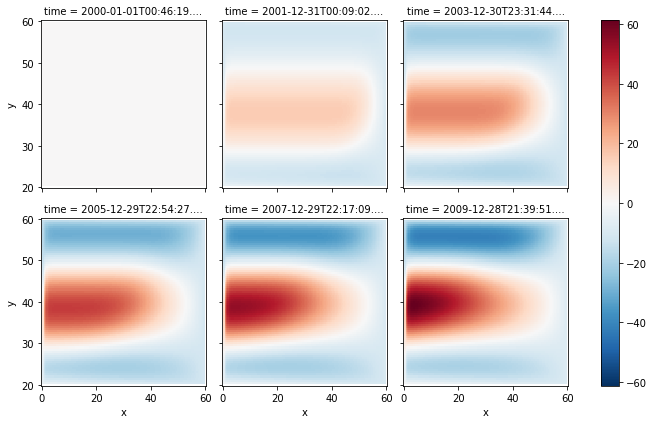

In [8]:
import xarray as xr

eta = xr.combine_by_coords([v.as_dataarray for v in output])

eta.plot(x='x', y='y', col="time", col_wrap=3);

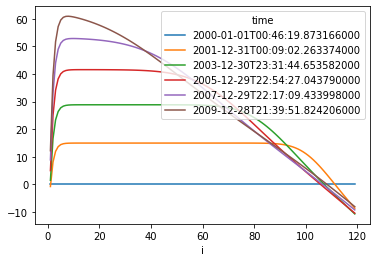

In [9]:
eta.isel(j=40).plot(hue="time");